# **Credit Card Fraud Prediction**

This notebook aims to predict credit card fraud using machine learning techniques. We'll explore the dataset, preprocess it to handle imbalances, train multiple models, and optimize them for better fraud detection. The dataset contains transactions with anonymized features (`V1`–`V28`), `Time`, `Amount`, and a binary `Class` label (0 for non-fraud, 1 for fraud).

## **(1) Importing Required Libraries**

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score

from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, recall_score

## **(2) Load Data**

In [2]:
# Load Data
df = pd.read_csv('creditcard.csv')

## **(3) Exploratory Data Analysis (EDA)**

Let’s dive into the data to understand its structure, distributions, and patterns. Since fraud detection often hinges on subtle differences, we’ll focus on class imbalance, feature distributions, and temporal trends.

In [ ]:
# Basic Information
print("Dataset Shape:", df.shape)

Dataset Shape: (284807, 31)


In [6]:
#Concise Summary of the DataFrame
print("\nDataset Info:")
df.info()



Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64


In [7]:
#Having a look at the first 5 rows of the dataset
print("\nFirst 5 Rows:\n", df.head())


First 5 Rows:
    Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26     

In [ ]:
#General Statistics of the dataset With respect to columns
print("\nSummary Statistics:\n", df.describe())


Summary Statistics:
                 Time            V1            V2            V3            V4  \
count  284807.000000  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean    94813.859575  1.168375e-15  3.416908e-16 -1.379537e-15  2.074095e-15   
std     47488.145955  1.958696e+00  1.651309e+00  1.516255e+00  1.415869e+00   
min         0.000000 -5.640751e+01 -7.271573e+01 -4.832559e+01 -5.683171e+00   
25%     54201.500000 -9.203734e-01 -5.985499e-01 -8.903648e-01 -8.486401e-01   
50%     84692.000000  1.810880e-02  6.548556e-02  1.798463e-01 -1.984653e-02   
75%    139320.500000  1.315642e+00  8.037239e-01  1.027196e+00  7.433413e-01   
max    172792.000000  2.454930e+00  2.205773e+01  9.382558e+00  1.687534e+01   

                 V5            V6            V7            V8            V9  \
count  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean   9.604066e-16  1.487313e-15 -5.556467e-16  1.213481e-16 -2.406331e-15   
std    1.380247e+00 

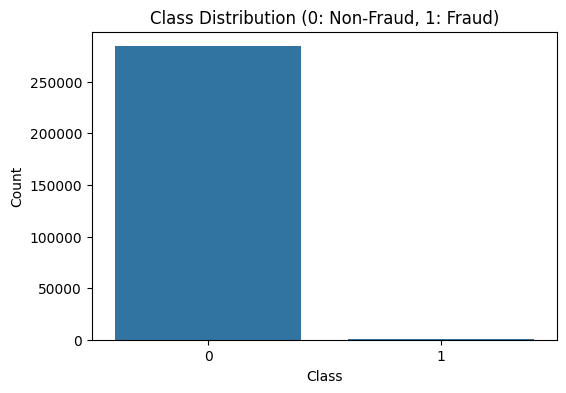

Class Distribution:
 Class
0    284315
1       492
Name: count, dtype: int64


In [11]:
# Class Distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='Class', data=df)
plt.title('Class Distribution (0: Non-Fraud, 1: Fraud)')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()
class_counts = df['Class'].value_counts()
print("Class Distribution:\n", class_counts)

In [12]:
#Percentage of Fraudulent Transactions in the dataset
print("Fraud Percentage: {:.2f}%".format(100 * class_counts[1] / len(df)))

Fraud Percentage: 0.17%


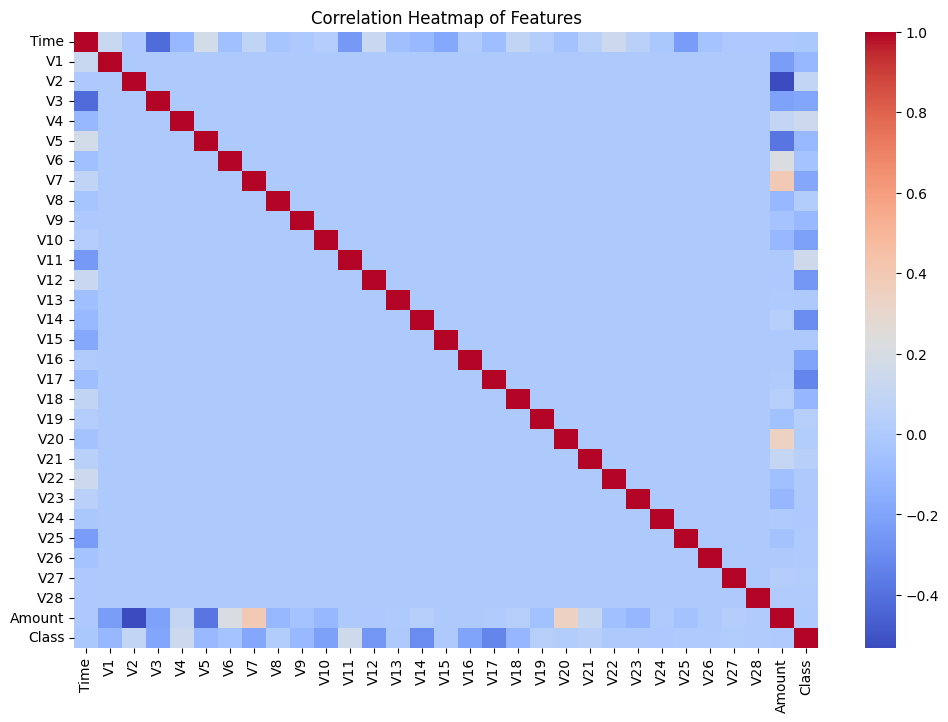

In [14]:
# Correlation Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), cmap='coolwarm', annot=False)
plt.title('Correlation Heatmap of Features')
plt.show()
class_corr = df.corr()['Class'].sort_values(ascending=False)

In [20]:
#Top 10 Positive and Negative Correlations with Class
print("Top Correlations with Class:\n", class_corr.head(3), "\nWorst Correlations with Class:\n", class_corr.tail(3))

Top Correlations with Class:
 Class    1.000000
V11      0.154876
V4       0.133447
Name: Class, dtype: float64 
Worst Correlations with Class:
 V12   -0.260593
V14   -0.302544
V17   -0.326481
Name: Class, dtype: float64


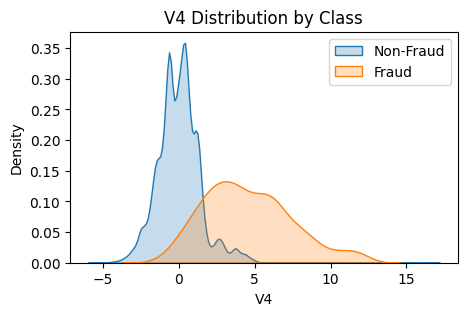

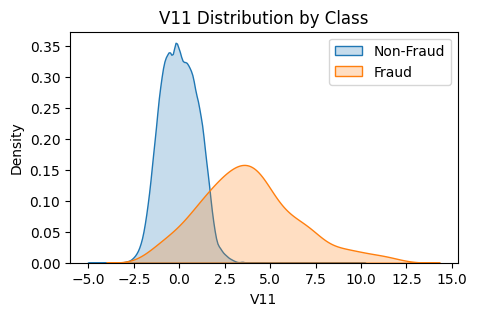

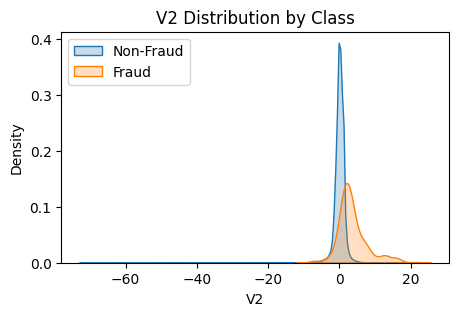

In [24]:
# Feature Distributions by Class for Top Correlations 
for feature in ["V4", "V11", "V2"]:
    plt.figure(figsize=(5, 3))
    sns.kdeplot(data=df[df['Class'] == 0], x=feature, label='Non-Fraud', fill=True)
    sns.kdeplot(data=df[df['Class'] == 1], x=feature, label='Fraud', fill=True)
    plt.title(f'{feature} Distribution by Class')
    plt.legend()
    plt.show()

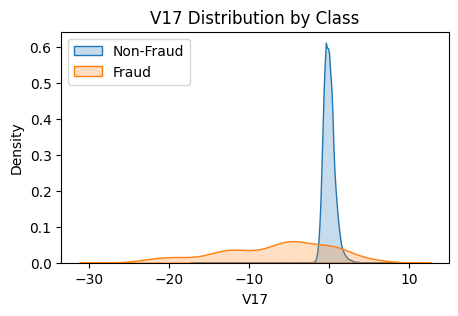

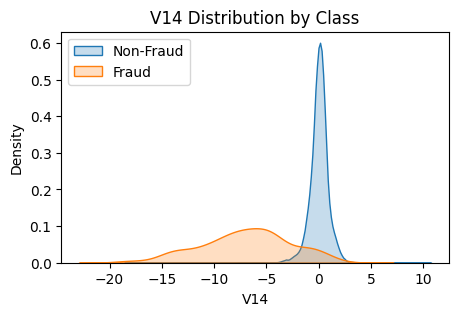

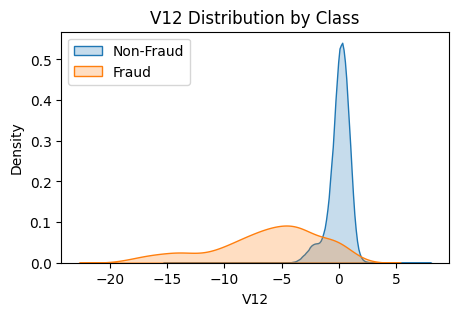

In [23]:
# Feature Distributions by Class for Worst Correlations 
for feature in ["V17", "V14", "V12"]:
    plt.figure(figsize=(5, 3))
    sns.kdeplot(data=df[df['Class'] == 0], x=feature, label='Non-Fraud', fill=True)
    sns.kdeplot(data=df[df['Class'] == 1], x=feature, label='Fraud', fill=True)
    plt.title(f'{feature} Distribution by Class')
    plt.legend()
    plt.show()

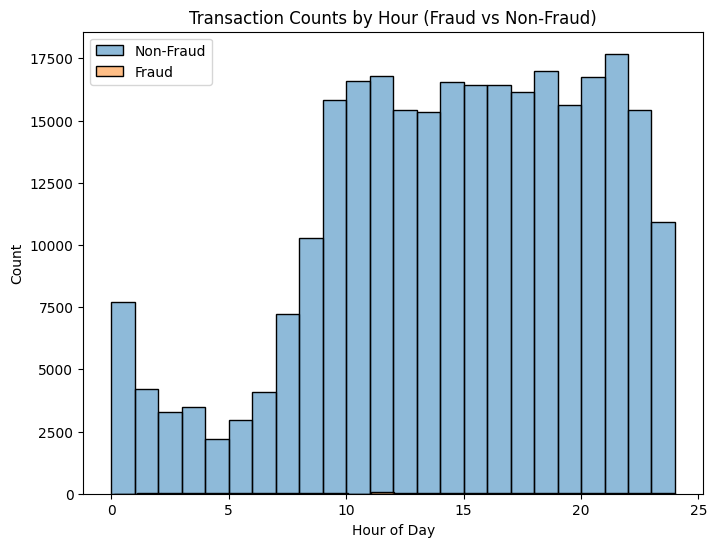

In [26]:
# Time Distribution
df['Hour'] = df['Time'] / 3600 % 24  # Convert to hours
plt.figure(figsize=(8, 6))
sns.histplot(data=df[df['Class'] == 0], x='Hour', bins=24, label='Non-Fraud', alpha=0.5)
sns.histplot(data=df[df['Class'] == 1], x='Hour', bins=24, label='Fraud', alpha=0.5)
plt.title('Transaction Counts by Hour (Fraud vs Non-Fraud)')
plt.xlabel('Hour of Day')
plt.ylabel('Count')
plt.legend()
plt.show()

### **EDA Insights**
- The dataset is highly imbalanced (~0.17% fraud), which will require special handling.
- Some `V` features (e.g., `V4`, `V11`) show strong correlations with `Class`, suggesting they’re key predictors.
- Fraudulent transactions may cluster at certain hours, indicating temporal patterns.

## **(4) Data Preprocessing**

We’ll preprocess the data by engineering features, scaling, and splitting it into train/validation/test sets.

In [29]:
# Feature Engineering
df['Amount_to_Mean'] = df['Amount'] / df['Amount'].mean()
hourly_fraud_rate = df.groupby('Hour')['Class'].mean().to_dict()
df['Hourly_Fraud_Rate'] = df['Hour'].map(hourly_fraud_rate)
df['Log_Amount'] = np.log1p(df['Amount'].clip(lower=0))  # Handle negatives

In [32]:
# Scaling Features
scaler = StandardScaler()
features_to_scale = ['Amount', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
                     'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
                     'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28']
df[features_to_scale] = scaler.fit_transform(df[features_to_scale])

In [35]:
# Split Features and Target
X = df.drop(columns=['Class', 'Time'])  # Drop Time as we have Hour
y = df['Class']

In [36]:
# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train_final, X_val, y_train_final, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

print(f"Train set: {X_train_final.shape}, Validation set: {X_val.shape}, Test set: {X_test.shape}")

Train set: (182276, 33), Validation set: (45569, 33), Test set: (56962, 33)


## **(5) Handle Imbalanced Data**

The class imbalance (99.83% non-fraud vs. 0.17% fraud) can bias models toward the majority class. We’ll use SMOTE to oversample the minority class.

In [37]:
# Apply SMOTE
smote = SMOTE(sampling_strategy=0.2, random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_final, y_train_final)

print("Before SMOTE:\n", y_train_final.value_counts())
print("After SMOTE:\n", pd.Series(y_train_resampled).value_counts())

Before SMOTE:
 Class
0    181961
1       315
Name: count, dtype: int64
After SMOTE:
 Class
0    181961
1     36392
Name: count, dtype: int64


## **(6) Model Training**

We’ll train Logistic Regression, Random Forest, and XGBoost, evaluating them with cross-validation and visualizations.

In [38]:
# Define Models
models = {
    "Logistic Regression": LogisticRegression(solver='liblinear', random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(eval_metric='logloss', random_state=42)
}



🔹 Training Logistic Regression...
Logistic Regression - CV ROC-AUC: 0.9999 (± 0.0000)
Logistic Regression - Validation Set:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     45490
           1       0.54      0.94      0.69        79

    accuracy                           1.00     45569
   macro avg       0.77      0.97      0.84     45569
weighted avg       1.00      1.00      1.00     45569

ROC-AUC Score: 0.9979


<Figure size 800x600 with 0 Axes>

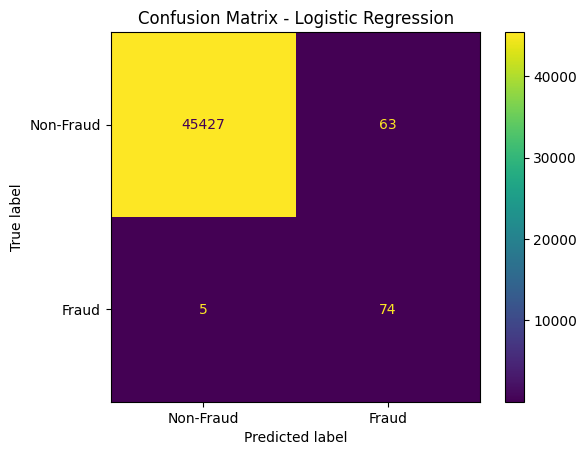


🔹 Training Random Forest...
Random Forest - CV ROC-AUC: 1.0000 (± 0.0000)
Random Forest - Validation Set:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     45490
           1       0.92      0.87      0.90        79

    accuracy                           1.00     45569
   macro avg       0.96      0.94      0.95     45569
weighted avg       1.00      1.00      1.00     45569

ROC-AUC Score: 0.9999


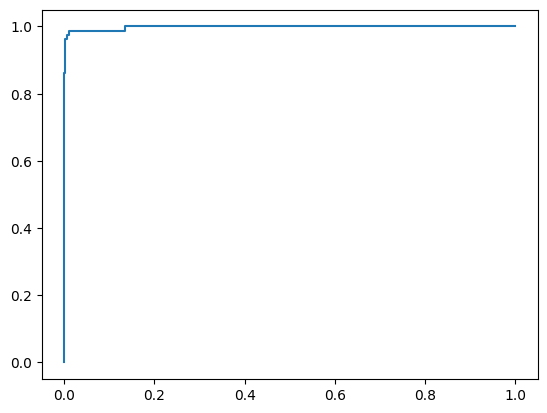

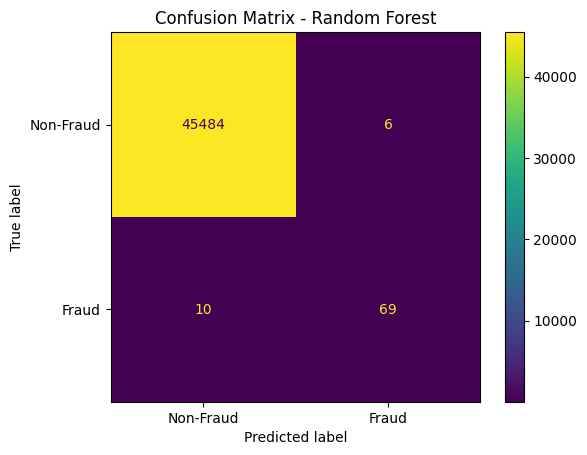


🔹 Training XGBoost...
XGBoost - CV ROC-AUC: 1.0000 (± 0.0000)
XGBoost - Validation Set:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     45490
           1       0.87      0.91      0.89        79

    accuracy                           1.00     45569
   macro avg       0.93      0.96      0.94     45569
weighted avg       1.00      1.00      1.00     45569

ROC-AUC Score: 0.9997


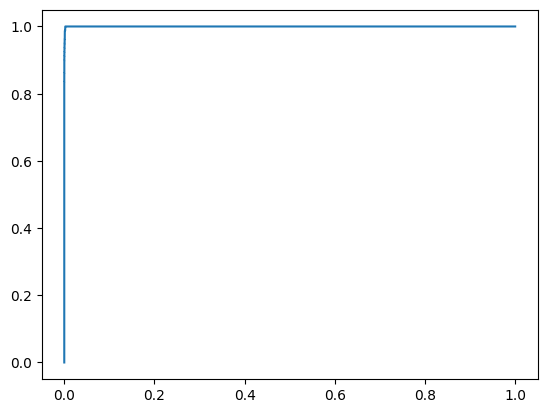

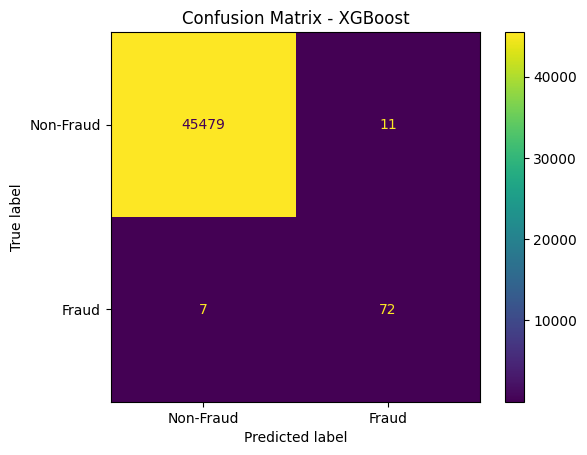

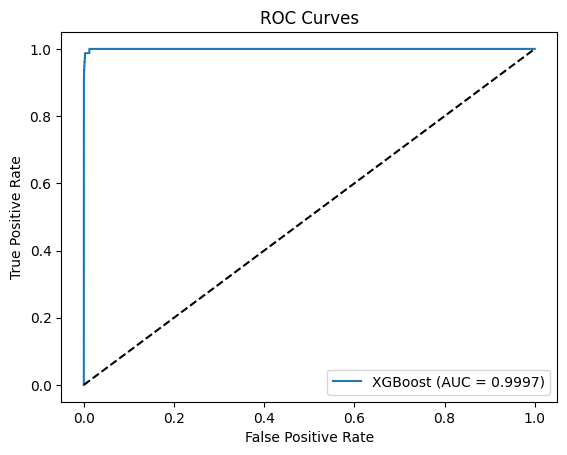

In [39]:
# Train and Evaluate
plt.figure(figsize=(8, 6))
for name, model in models.items():
    print(f"\n🔹 Training {name}...")
    model.fit(X_train_resampled, y_train_resampled)
    
    # Cross-Validation
    cv_scores = cross_val_score(model, X_train_resampled, y_train_resampled, cv=5, scoring='roc_auc')
    print(f"{name} - CV ROC-AUC: {cv_scores.mean():.4f} (± {cv_scores.std():.4f})")
    
    # Validation Prediction
    y_val_pred = model.predict(X_val)
    y_val_prob = model.predict_proba(X_val)[:, 1]
    print(f"{name} - Validation Set:\n", classification_report(y_val, y_val_pred))
    print(f"ROC-AUC Score: {roc_auc_score(y_val, y_val_prob):.4f}")
    
    # Confusion Matrix
    ConfusionMatrixDisplay.from_predictions(y_val, y_val_pred, display_labels=['Non-Fraud', 'Fraud'])
    plt.title(f'Confusion Matrix - {name}')
    plt.show()
    
    # ROC Curve
    fpr, tpr, _ = roc_curve(y_val, y_val_prob)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc_score(y_val, y_val_prob):.4f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curves')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

## **(7) Hyperparameter Tuning**

We’ll optimize XGBoost (the best-performing model) using RandomizedSearchCV, focusing on recall to catch more fraud cases.

In [ ]:
# Define Random Forest and Parameter Grid
rf_model = RandomForestClassifier(random_state=42)
param_dist = {
    'n_estimators': [100, 200, 300], 
    'max_depth': [10, 20, None],  # Maximum depth of the tree, None allows full growth 
    'min_samples_split': [2, 5, 10],  # Minimum samples required to split a node 
    'max_features': ['auto', 'sqrt', 'log2'],  # Number of features to consider at each split 
    'class_weight': [None, 'balanced', {0: 1, 1: 10}, {0: 1, 1: 50}]  # Handle class imbalance
}


In [46]:
# Custom Recall Scorer
recall_scorer = make_scorer(recall_score, pos_label=1)

# Randomized Search
random_search = RandomizedSearchCV(rf_model, param_dist, n_iter=50, cv=3, scoring=recall_scorer, n_jobs=-1, verbose=2, random_state=42)
random_search.fit(X_train_resampled, y_train_resampled)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


c:\Users\rkpat\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
54 fits failed out of a total of 150.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
36 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\rkpat\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\rkpat\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "c:\Users\rkpat\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.p

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'class_weight': [None, 'balanced',
                                                         {0: 1, 1: 10},
                                                         {0: 1, 1: 50}],
                                        'max_depth': [10, 20, None],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300]},
                   random_state=42,
                   scoring=make_scorer(recall_score, response_method='predict', pos_label=1),
                   verbose=2)

In [47]:
# Best Model
best_rf = random_search.best_estimator_
print("Best Parameters:", random_search.best_params_)
y_val_pred = best_rf.predict(X_val)
print("Tuned Random Forest - Validation Set:\n", classification_report(y_val, y_val_pred))

Best Parameters: {'n_estimators': 100, 'min_samples_split': 10, 'max_features': 'log2', 'max_depth': 20, 'class_weight': 'balanced'}
Tuned Random Forest - Validation Set:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     45490
           1       0.91      0.90      0.90        79

    accuracy                           1.00     45569
   macro avg       0.96      0.95      0.95     45569
weighted avg       1.00      1.00      1.00     45569



In [48]:

# Threshold Tuning
y_val_prob = best_rf.predict_proba(X_val)[:, 1]
thresholds = [0.1, 0.3, 0.5, 0.7]
for thresh in thresholds:
    y_val_pred_adj = (y_val_prob >= thresh).astype(int)
    print(f"Threshold: {thresh}\n", classification_report(y_val, y_val_pred_adj))

Threshold: 0.1
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     45490
           1       0.45      0.99      0.62        79

    accuracy                           1.00     45569
   macro avg       0.72      0.99      0.81     45569
weighted avg       1.00      1.00      1.00     45569

Threshold: 0.3
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     45490
           1       0.77      0.91      0.83        79

    accuracy                           1.00     45569
   macro avg       0.88      0.96      0.92     45569
weighted avg       1.00      1.00      1.00     45569

Threshold: 0.5
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     45490
           1       0.91      0.90      0.90        79

    accuracy                           1.00     45569
   macro avg       0.96      0.95      0.95     45569
weighted avg       1.00   

## **(8) Final Test Evaluation**

Evaluate the tuned XGBoost model on the test set to assess its real-world performance.

Tuned Random Forest - Test Set:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.89      0.92      0.90        98

    accuracy                           1.00     56962
   macro avg       0.95      0.96      0.95     56962
weighted avg       1.00      1.00      1.00     56962

ROC-AUC Score: 0.9999


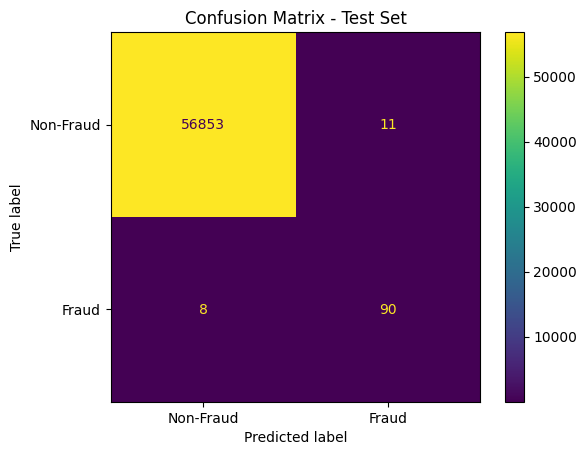

In [49]:
# Test Set Prediction
y_test_pred = best_rf.predict(X_test)
y_test_prob = best_rf.predict_proba(X_test)[:, 1]

# Performance Evaluation
print("Tuned Random Forest - Test Set:\n", classification_report(y_test, y_test_pred))
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_test_prob):.4f}")
ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred, display_labels=['Non-Fraud', 'Fraud'])
plt.title('Confusion Matrix - Test Set')
plt.show()

## **(9) Conclusion**

- **Key Features**: Features like `V4`, `V11`, and `Hourly_Fraud_Rate` likely drive fraud detection.
- **Performance**: The tuned XGBoost model improves recall, catching more fraud cases, though precision may drop.
- **Trade-offs**: Lower thresholds increase recall but raise false positives, impacting customer experience.
- **Next Steps**: Test ensemble methods or collect more fraud data to further boost performance.